#### Project in CMPE 252, Spring 2022, SJSU.

**Model-free learing in the tabular case by Q-learning**.

# Team 5

Dheeraj Skandakumar Nair<br>
Krupaben Kothadia<br>
Ramya Kotha<br>

In [28]:
#Importing the necessary libraries:
import matplotlib.pyplot as plt

from IPython.display import clear_output
import numpy as np
import random
import copy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Initialize the environment as per the problem statement:

In [29]:
GRID_SIZE = 17

# rewards
R_GOAL = 0
R_HIT_WALL = -5
R_STEP = -1 # each step is penalized, which encourage the agent
            # to look for the shortest path to the goal state

START = (0, 0)
GOAL = (GRID_SIZE - 1, GRID_SIZE - 1)

# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# Noise in transition 
ALPHA = 0.01


A_LIST = ['up', 'down', 'left', 'right', 'stay']

# lenght of an episode
EPISODE_LENGTH_MAX = 400

Define the Maze. 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell

In [30]:
# State Space
S = np.zeros((GRID_SIZE, GRID_SIZE))

# horizontal walls
S[3, 0:12] = 1
S[5, 10: ] = 1
S[8, 3:12] = 1
S[11, 4: ] = 1

# vertical walls
S[8:12, 2] = 2

# goal state
S[GOAL]    = 3

Visualize the maze

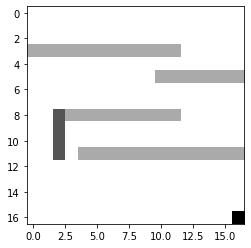

In [31]:
plt.imshow(S, cmap='binary')

State transition dynamics check

In [32]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE - 1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) \
        or (S[curr]==2 and action==3) \
        or (S[s_new]==1 and action==0)\
        or (S[s_new]==2 and action==2):
        return True

    return False

We assume that the environment assigns rewards using the following reward function. Note that this reward function is not known to the agent, but rather it gets only samples of rewards and next states given the current state and action.  

In [33]:
def R(s, a):
    '''Reward function for the agent
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return R_GOAL
    elif hit_wall(s, a):
        return R_HIT_WALL
    else:
        return R_STEP

We define a utility function s_next_calc, which calculates the next state given current state and action:

In [34]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

The agent will use the following function to stochastically perform an action and obtains the next state and the associated reward.

In [35]:
def step(s, a):
    '''This function stochastically performs the action 'a' on the given
    state s.
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid and the reward
    '''
    action_list = [a]
    cum_prob_list = [1 - ALPHA]
    for action in range(len(A)):
        if action != a:
            action_list.append(action)
            cum_prob_list.append(ALPHA/4)

    action_taken = random.choices(action_list, cum_weights=cum_prob_list)[0]
    r = R(s, action_taken)
    if r == R_HIT_WALL or R_GOAL: # can't move
        s_next = s
    else:
        s_next = s_next_calc(s, action_taken)
    return s_next, r
    

We will use the following epsilon-greedy choice of an action

In [36]:
def choose_action_epsilon(Q, s, epsilon):
    """return a string action"""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(A)-1)
    return np.argmax(Q[s[0], s[1], :])
    

**Remider**: Q-learning algorithm is:
![Screen%20Shot%202022-05-01%20at%204.51.08%20PM.png](attachment:Screen%20Shot%202022-05-01%20at%204.51.08%20PM.png)

In [37]:
def plot_policy_from_qtable(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]
    for k, v in np.ndenumerate(policy):
        plt.quiver(k[1], k[0], quiver_action_dict[v][1], quiver_action_dict[v][0])
    plt.show()

In [38]:
#The agent uses the following function for Q-Learning:
def q_learning(gamma, episodes, epsilon, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param epsilon: probability not to take an optimal action
    : param episodes: Number of episodes for training
    : returns: dicounted accumulated reward
    '''
    plt.ion()

    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        s = START
        r_sum = 0
        i = 1

        while s != GOAL and i < EPISODE_LENGTH_MAX:
            # Pick the best known or random action according to eps
            a = choose_action_epsilon(Q, s, epsilon)

            # Take a random action with a transition probability ALPHA
            s_next, r = step(s, a)

            # Update Q table
            max_Q_next = max(Q[s_next[0],s_next[1],:])
            Q[s[0]][s[1]][a] += r + gamma*max_Q_next - Q[s[0],s[1],a]
            
            s = s_next
            r_sum += r
            i += 1

        sum_steps += i
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    return r_list, Q

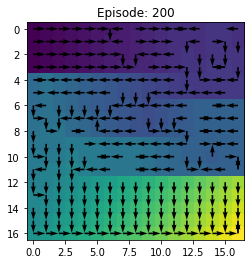

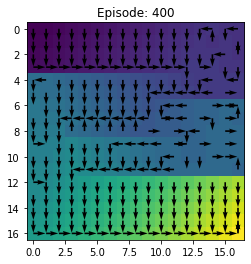

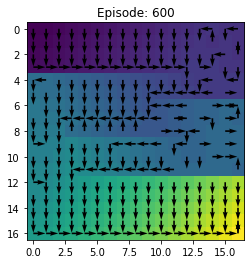

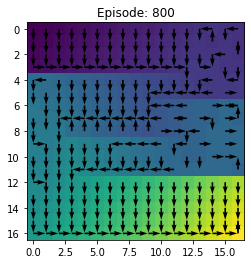

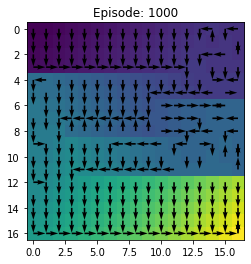

In [39]:
# example of running
episodes = 1000
gamma    = 0.975
epsilon  = 0.01
r_list,Q   = q_learning(gamma,  episodes, epsilon)

In [40]:
len(r_list)

1000

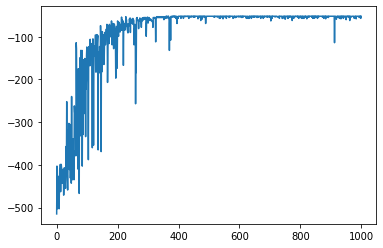

In [41]:
x = [i for i in range(1000)]
y = r_list
plt.plot(x,y)
plt.show()

**Task 1**: run 5 times q_learning for episodes=1000, gamma=0.975 and epsilon = 0.01. 

Plot on plt.subplot(131) a) the curve of the accumulated discounted reward as a function of the episode number, averaged over these 5  runs, b) the variance of these 5 runs, using e.g., the function 'fill_between'. 

Plot on plt.subplot(132) a) the value function on the maze layout, V(s), for one of these 5 runs, and b) its corresponding optimal policy by arrows (UP, DOWN, etc), pi(s).

Plot on plt.subplot(133): 3 trajectories of states by an optimal policy from 3 random START states. 

--
add titles, axis labels, and legends.  

In [42]:
# Running 5 times q_learning function for episodes=1000, gamma=0.975 and epsilon = 0.01 and storing them into sub arrays
r_list = []
q_list = []
for i in range(5):
    r1, q1 = q_learning(gamma,  episodes, epsilon,show=False)
    r_list.append(r1)
    q_list.append(q1)

In [43]:
# Calculating average of 5 runs 
r5_avg= np.zeros((1000))
x = [j for j in range(1000)]

for i in range(5):
    r5_avg+= np.array(r_list[i])
r5_avg= r5_avg/ 5; 

In [44]:
def q_learning_start_state(gamma, episodes, epsilon, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param epsilon: probability not to take an optimal action
    : param episodes: Number of episodes for training
    : returns: dicounted accumulated reward
    '''
    plt.ion()

    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    states = []
    r_list = []
    sum_steps = 0
    START = (random.randint(0,GRID_SIZE-1),random.randint(0,GRID_SIZE-1))
    states.append(START)
    
    for episode in range(episodes):
        s = START
        r_sum = 0
        i = 1

        while s != GOAL and i < EPISODE_LENGTH_MAX:
            # Pick the best known or random action according to eps
            a = choose_action_epsilon(Q, s, epsilon)
            
            # Take a random action with a transition probability ALPHA
#             print("a: ",a,"\n")
            s_next, r = step(s, a)
#             print(s_next[0],", ",s_next[1],"\n")
            # Update Q table
            max_Q_next = max(Q[s_next[0],s_next[1],:])
#             print(max_Q_next,"\n")
            Q[s[0]][s[1]][a] += r + gamma*max_Q_next - Q[s[0],s[1],a]
            
            s = s_next
#             print(s[0],", ",s[1],"\n") 
            r_sum += r
            i += 1

        sum_steps += i
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))
    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    return START,Q

In [45]:
Start1, Q_test1 = q_learning_start_state(gamma,  episodes, epsilon, show=False)
Start2, Q_test2 = q_learning_start_state(gamma,  episodes, epsilon, show=False)
Start3, Q_test3 = q_learning_start_state(gamma,  episodes, epsilon, show=False)

In [46]:
def OptimalPolicyStates(Start,Q):
    stateListPath = [] 
    stateListPath.append(Start) 
    curr_state= Start #(x,y)
    while (curr_state!= GOAL):
        optimal_policy = np.argmax(Q[curr_state[0],curr_state[1],:])
        next_state = s_next_calc(curr_state,optimal_policy)
        stateListPath.append(next_state)
        curr_state= next_state
    return stateListPath

In [47]:
# Calculate State List path
stateListPath1 = OptimalPolicyStates(Start1,Q_test1)
stateListPath2 = OptimalPolicyStates(Start2,Q_test2)
stateListPath3 = OptimalPolicyStates(Start3,Q_test3)

In [48]:
def plotOptimalPolicyStates(stateList1,stateList2,stateList3):
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []
    x_3 = []
    y_3 = []
    for i in stateList1:
        x_1.append(i[0])
        y_1.append(i[1])
    for i in stateList2:
        x_2.append(i[0])
        y_2.append(i[1])
    for i in stateList3:
        x_3.append(i[0])
        y_3.append(i[1])
        
    plt.plot(y_1,x_1,'c-*')
    plt.plot(y_2,x_2,'m-^')
    plt.plot(y_3,x_3,'y-o')
    plt.legend(['randStart1','randStart2','randStart3'])
    plt.xlim([0,17])
    plt.ylim([0,17])
    plt.gca().invert_yaxis()
    plt.title("Maze")

In [49]:
def plot_policy_from_valueFunction(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]
    for k, v in np.ndenumerate(policy):
        plt.quiver(k[1], k[0], quiver_action_dict[v][1], quiver_action_dict[v][0])
    plt.show()

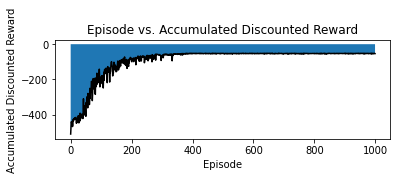

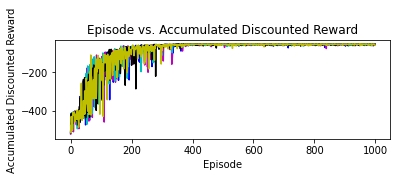

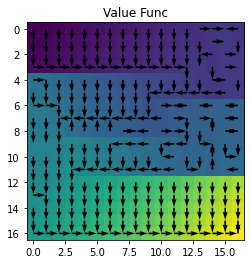

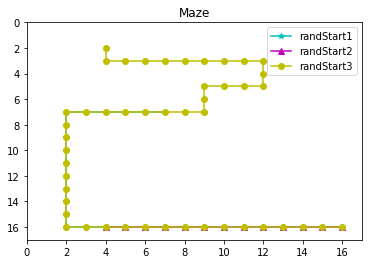

In [50]:
# Task 1.1  a), b)
x = [j for j in range(1000)]


plt.subplot(211)
plt.plot(x,r5_avg,'k')
plt.fill_between(x,r5_avg ,)
plt.xlabel("Episode")
plt.ylabel("Accumulated Discounted Reward")
plt.title("Episode vs. Accumulated Discounted Reward")
plt.show()



plt.subplot(212)
plt.plot(x,r_list[0],'b')
plt.plot(x,r_list[1],'m')
plt.plot(x,r_list[2],'c')
plt.plot(x,r_list[3],'k')
plt.plot(x,r_list[4],'y')
plt.xlabel("Episode")
plt.ylabel("Accumulated Discounted Reward")
plt.title("Episode vs. Accumulated Discounted Reward")
plt.show()

# Task 1.2 a), b)

plot_policy_from_valueFunction(q_list[1], msg="Value Func") 

#Task 1.3
plotOptimalPolicyStates(stateListPath1,stateListPath2,stateListPath3)

Same using subplots

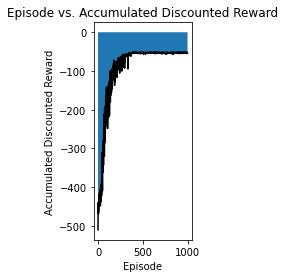

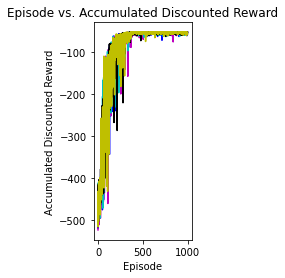

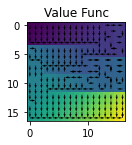

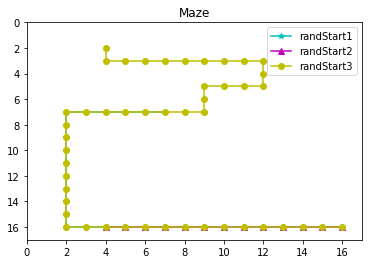

In [51]:
x = [j for j in range(1000)]
plt.subplot(131)

plt.plot(x,r5_avg,'k')
plt.fill_between(x,r5_avg ,)
plt.xlabel("Episode")
plt.ylabel("Accumulated Discounted Reward")
plt.title("Episode vs. Accumulated Discounted Reward")
plt.show()
plt.subplot(131)

plt.plot(x,r_list[0],'b')
plt.plot(x,r_list[1],'m')
plt.plot(x,r_list[2],'c')
plt.plot(x,r_list[3],'k')
plt.plot(x,r_list[4],'y')
plt.xlabel("Episode")
plt.ylabel("Accumulated Discounted Reward")
plt.title("Episode vs. Accumulated Discounted Reward")
plt.show()


plt.subplot(132)
plot_policy_from_valueFunction(q_list[1], msg="Value Func") 


plotOptimalPolicyStates(stateListPath1,stateListPath2,stateListPath3)

**Task 2**: repeat Task 1 for epsilon = [0.005, 0.2] and gamma=[0.9, 0.75] and show the results on 4 different figures, respectively. Add a title to each figure indicating epsilon and gamma.

In [54]:
episodes = 1000
gamma_list = [0.9,0.75]
epsilon_list = [0.005,0.2]
titles = [] 
Q_List = []
for gamma in gamma_list:
    for epsilon in epsilon_list:
        titles.append((gamma,epsilon))
        r1, q1 = q_learning(gamma,  episodes, epsilon,show=False)
        Q_List.append(q1)

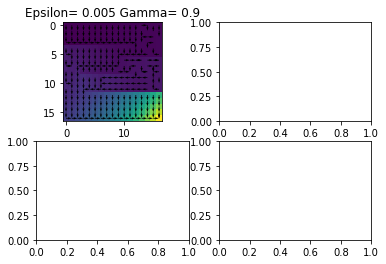

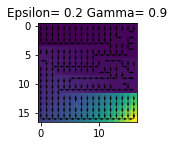

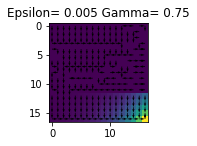

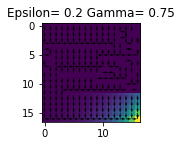

In [55]:
fig, axs = plt.subplots(2, 2)
for i,_ in enumerate(Q_List):
    plt.subplot(2,2,i + 1)
    plot_policy_from_qtable(Q_List[i],"Epsilon= "+str(titles[i][1])+" Gamma= "+str(titles[i][0]))
fig.tight_layout()

**Task 3**: explain your observations and conclusions. 

**Please submit this runnable notebook and a corresponding PDF.**




*   The Q-learning algorithm has a high-speed performance than the conventional policy or value iteration in terms of computation and since it's a finite horizon there is no requirement of updation of the Q table.

*   The graph of episode vs accumulated discount rewards shows that with increase in episodes the graph starts to rise from 0 and increases w.r.t both the accumulated discout rewards and till 250 episodes and then after increases w.r.t just the episodes and remaining stable at -50 discounted reward going to infinity.

*   The agent's action is dependent on the epsilon value and so it's observed that higher the epsilon value higher the randomness in the agent's actions.

*   By experimenting with the epsilon and gamma values, we observed that when epsilon is fixed and if gamma is lower then the discounted factor for rewards is lower. This is shown in task 2.












